<a href="https://colab.research.google.com/github/chipojaya1/myNEBDHub/blob/main/Japan_case_study_Milestone__2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color='crimson'>**Milestone #2 - Applying Analytical Strategies**</font>

### Getting Started

In [2]:
# Loading necessary libraries for time series analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set_style('darkgrid')

import warnings
warnings.simplefilter("ignore")

In [3]:
# Getting started
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


#### **Time Series Analysis**

In [4]:
# Load datframe as jp
df_jp = pd.read_csv('/content/drive/MyDrive/Analyzing_Pandemic_Responses/data/df_clean.csv')
df_jp.head()

,CountryName,CountryCode,Jurisdiction,Date,C1M_School closing,C1M_Flag,C2M_Workplace closing,C2M_Flag,C3M_Cancel public events,C3M_Flag,...,MajorityVaccinated,PopulationVaccinated,StringencyIndex_Average,GovernmentResponseIndex_Average,ContainmentHealthIndex_Average,EconomicSupportIndex,DailyCases,DailyDeaths,Cases_7dayAvg,Deaths_7dayAvg
0,Japan,JPN,NAT_TOTAL,2020-01-01,0.0,False,0.0,False,0.0,False,...,NV,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,Japan,JPN,NAT_TOTAL,2020-01-02,0.0,False,0.0,False,0.0,False,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Japan,JPN,NAT_TOTAL,2020-01-03,0.0,False,0.0,False,0.0,False,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Japan,JPN,NAT_TOTAL,2020-01-04,0.0,False,0.0,False,0.0,False,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Japan,JPN,NAT_TOTAL,2020-01-05,0.0,False,0.0,False,0.0,False,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Data Prep**

In [5]:
# Set the 'Date' column as the index
df_jp['Date'] = pd.to_datetime(df_jp['Date'])
df_jp = df_jp.set_index('Date')

wk = pd.DataFrame({
    'weekly_cases': df_jp['DailyCases'].resample('W-SUN').sum(),
    'stringency_wk': df_jp['StringencyIndex_Average'].resample('W-SUN').mean()
}).dropna()

# optional smoothing target for plotting
wk['cases_7w'] = wk['weekly_cases'].rolling(3, min_periods=1).mean()
wk = wk.asfreq('W-SUN')  # ensure frequency is set

**STL decomposition**

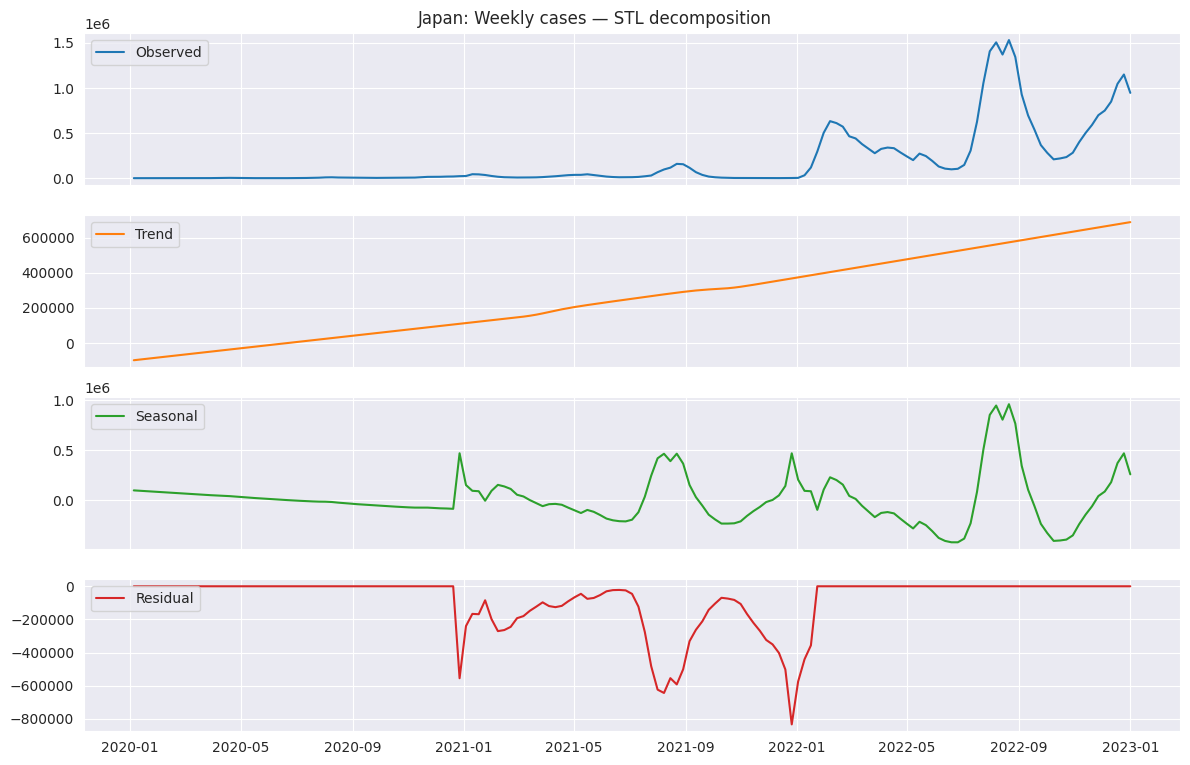

In [6]:
from statsmodels.tsa.seasonal import STL

y = wk['weekly_cases'].astype(float).fillna(0.0)
stl = STL(y, period=52, robust=True)  # weekly data → ~52 periods per year
res = stl.fit()

fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
axes[0].plot(wk.index, res.observed, label='Observed'); axes[0].legend(loc='upper left')
axes[1].plot(wk.index, res.trend, color='C1', label='Trend'); axes[1].legend(loc='upper left')
axes[2].plot(wk.index, res.seasonal, color='C2', label='Seasonal'); axes[2].legend(loc='upper left')
axes[3].plot(wk.index, res.resid, color='C3', label='Residual'); axes[3].legend(loc='upper left')
plt.suptitle('Japan: Weekly cases — STL decomposition', y=0.95)
plt.tight_layout()
plt.show()


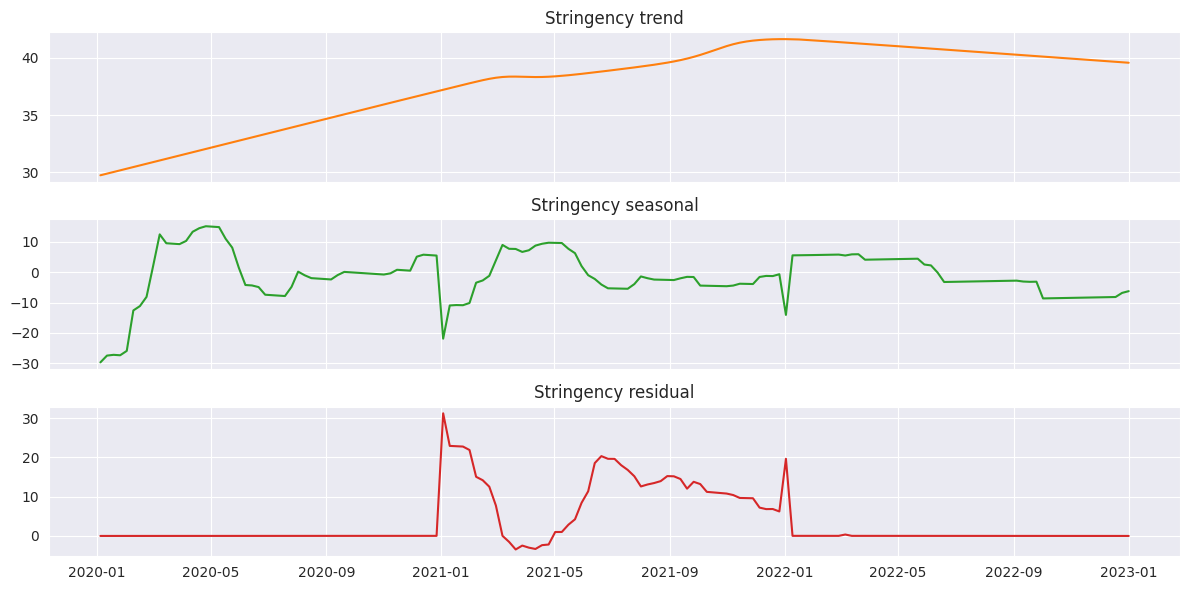

In [7]:
stl_s = STL(wk['stringency_wk'].astype(float).interpolate(limit_direction='both'), period=52, robust=True)
res_s = stl_s.fit()

fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
axes[0].plot(wk.index, res_s.trend, color='C1'); axes[0].set_title('Stringency trend')
axes[1].plot(wk.index, res_s.seasonal, color='C2'); axes[1].set_title('Stringency seasonal')
axes[2].plot(wk.index, res_s.resid, color='C3'); axes[2].set_title('Stringency residual')
plt.tight_layout()
plt.show()


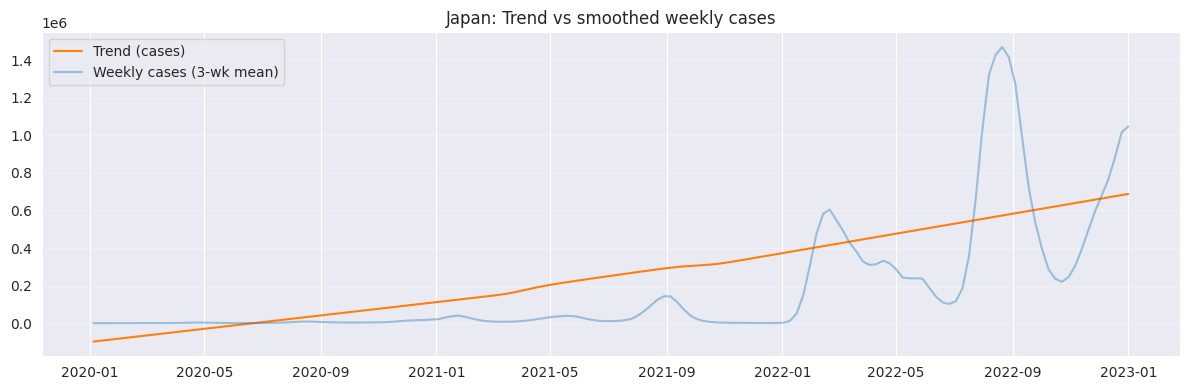

In [9]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(wk.index, res.trend, color='C1', label='Trend (cases)')
ax.plot(wk.index, wk['cases_7w'], color='C0', alpha=0.4, label='Weekly cases (3‑wk mean)')
ax.set_title('Japan: Trend vs smoothed weekly cases')
ax.legend(); ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout(); plt.show()

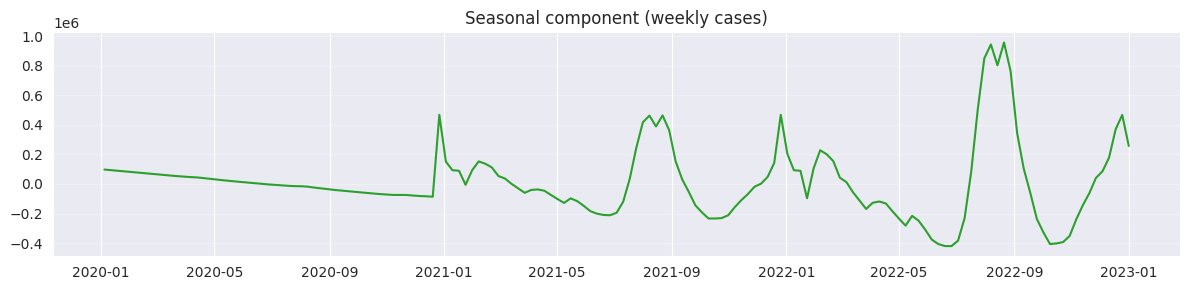

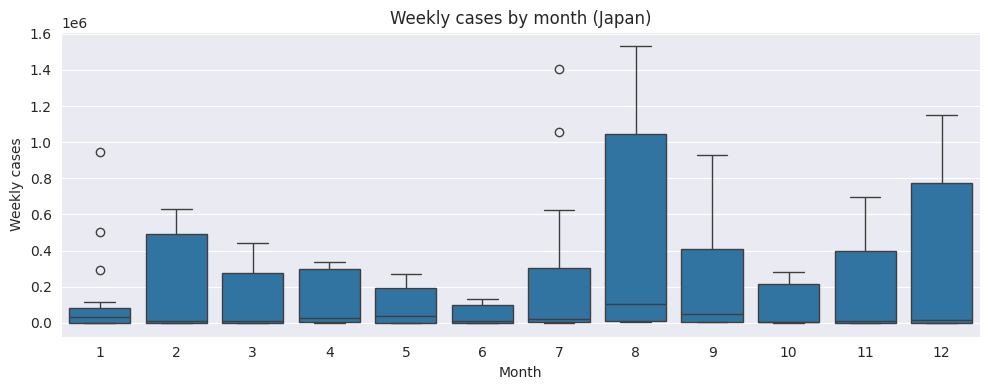

In [10]:
# 1) STL seasonal component
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(wk.index, res.seasonal, color='C2')
ax.set_title('Seasonal component (weekly cases)')
ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout(); plt.show()

# 2) Month-of-year seasonal plot (calendar view)
mview = wk.assign(month=wk.index.month, year=wk.index.year).dropna()
fig, ax = plt.subplots(figsize=(10,4))
sns.boxplot(data=mview, x='month', y='weekly_cases', ax=ax)
ax.set_title('Weekly cases by month (Japan)')
ax.set_xlabel('Month'); ax.set_ylabel('Weekly cases')
plt.tight_layout(); plt.show()


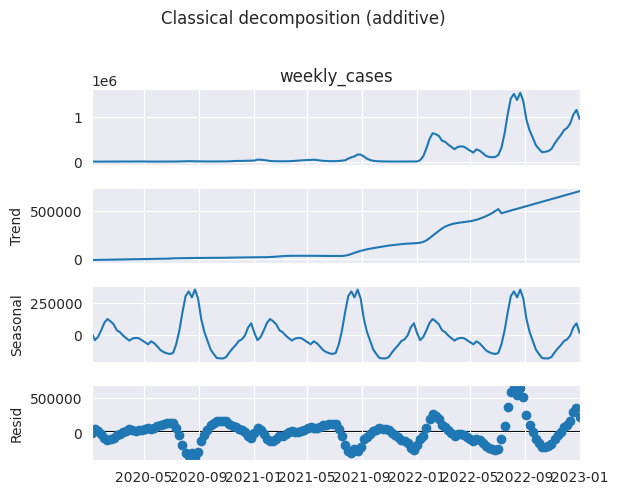

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
dec = seasonal_decompose(wk['weekly_cases'], model='additive', period=52, extrapolate_trend='freq')
dec.plot(); plt.suptitle('Classical decomposition (additive)', y=1.02); plt.tight_layout(); plt.show()


                               SARIMAX Results                                
Dep. Variable:           weekly_cases   No. Observations:                  157
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1939.813
Date:                Tue, 23 Sep 2025   AIC                           3885.627
Time:                        04:32:55   BIC                           3894.776
Sample:                    01-05-2020   HQIC                          3889.343
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4917      0.065      7.548      0.000       0.364       0.619
ma.L1          0.3955      0.050      7.835      0.000       0.297       0.494
sigma2      3.832e+09   1.62e-12   2.36e+21      0.0

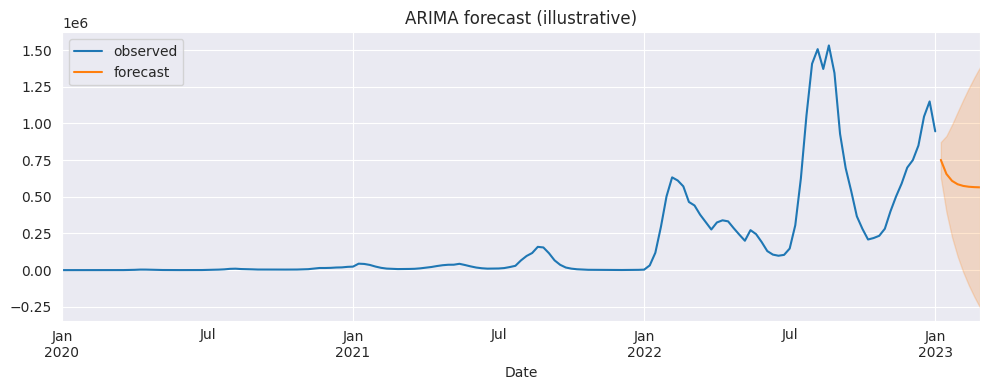

In [12]:
from statsmodels.tsa.arima.model import ARIMA

y = wk['weekly_cases'].astype(float)
# Example: simple ARIMA order; in practice pick via AIC/grid/diagnostics
model = ARIMA(y, order=(1,1,1))
fit = model.fit()
print(fit.summary())

# Forecast next 8 weeks
fc = fit.get_forecast(steps=8)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()

ax = y.plot(label='observed', figsize=(10,4))
fc_mean.plot(ax=ax, label='forecast')
ax.fill_between(fc_ci.index, fc_ci.iloc[:,0], fc_ci.iloc[:,1], color='C1', alpha=0.2)
ax.set_title('ARIMA forecast (illustrative)')
ax.legend(); plt.tight_layout(); plt.show()


#### **Machine Learning**